In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

In [3]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [4]:
ntrain = 1000
ntest = 500

# sub = 2**3 #subsampling rate
# h = 2**13 // sub #total grid size divided by the subsampling rate
# s = h

batch_size = 100
learning_rate = 0.001

epochs = 200
step_size = 50
gamma = 0.5

modes = 16
width = 64

In [5]:
dataloader = MatReader('data/x_data_kl4.mat')
x_data = dataloader.read_field('x')

x_train = x_data[:ntrain-1,:]
y_train = x_data[1:ntrain,:]
x_test = x_data[-ntest:-1,:]
y_test = x_data[-ntest+1:,:]

x_train = x_train.reshape(ntrain-1,200,1)
x_test = x_test.reshape(ntest-1,200,1)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)


torch.Size([999, 200, 1]) torch.Size([999, 200]) torch.Size([499, 200, 1]) torch.Size([499, 200])


In [6]:
# model
model = FNO1d(modes, width).to(device)
print(count_params(model))
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train_mse = []
train_l2 = []
test_l2 = []
myloss = LpLoss(size_average=False)

549569


In [7]:
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse.append(mse.item())
        train_l2.append(l2.item())

    scheduler.step()
    model.eval()
    
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            out = model(x)
            test_loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
            test_l2.append(test_loss)

    t2 = default_timer()
    if ep % 50 == 0:
        print("epoch:{}, time/epoch={:.3f},train_mse={:.6f}, train_loss={:.4f}, test_loss={:.4f}".format(\
                                ep, t2-t1, mse.item(), l2.item(), test_loss))

epoch:0, training time=3.181,train_mse=0.016077, train_loss=99.6381, test_loss=99.2223
epoch:50, training time=3.161,train_mse=0.000011, train_loss=2.7363, test_loss=2.8462
epoch:100, training time=2.971,train_mse=0.000005, train_loss=1.8892, test_loss=1.9406
epoch:150, training time=2.827,train_mse=0.000004, train_loss=1.6737, test_loss=1.6609


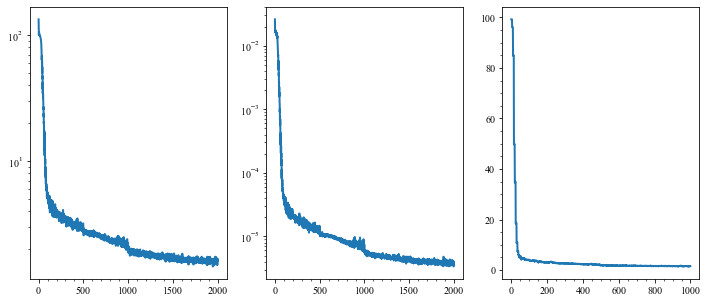

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.semilogy(train_l2)
plt.subplot(132)
plt.semilogy(train_mse)
plt.subplot(133)
plt.plot(test_l2)

In [11]:
torch.save(model, 'model/spring-mass-cpu2')
# model = torch.load('model/spring-mass-cpu2')

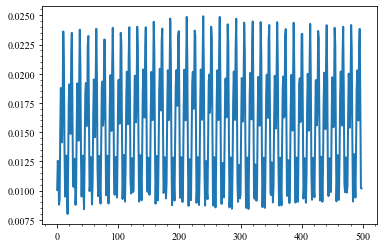

In [12]:
pred = torch.zeros(y_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
test_l2 = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        out = model(x).view(-1)
        pred[index] = out

        test_l2.append(myloss(out.view(1, -1), y.view(1, -1)).item())
#         print(index, test_l2)
        index = index + 1
plt.figure()
plt.plot(test_l2)

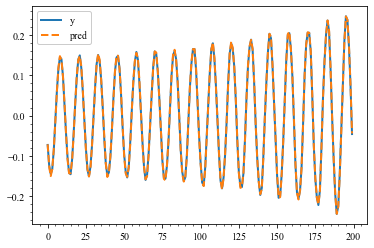

In [24]:
plt.figure()
idx = 100
# plt.plot(x_test[idx,:], label='x')
plt.plot(y_test[idx,:], label='y')
plt.plot(pred[idx, :],'--',label='pred')
plt.legend()
plt.show()

In [24]:
print(model(x_test[0,:].reshape(1,-1,1)).shape)
print(y_test[0,:].shape)

torch.Size([1, 200, 1])
torch.Size([200])


In [14]:
y_prec = torch.zeros(y_test.shape)
y_prec[0,:] = model(x_test[0,:].reshape([1,-1,1])).reshape(-1,)
with torch.no_grad():
    for i in range(y_test.shape[0]-1):
        idx = i+1
        y_prec[idx,:] = model(y_prec[idx-1,:].reshape([1,-1,1])).reshape(-1,)
y_prec = y_prec.detach().numpy()

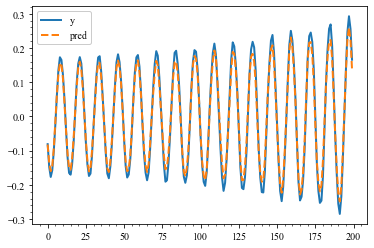

In [28]:
plt.figure()
idx = 15 # time id
# plt.plot(x_test[idx,:], label='x')
plt.plot(y_test[idx,:], label='y')
plt.plot(y_prec[idx, :],'--',label='pred')
plt.legend()
plt.show()  

Text(0, 0.5, 'time')

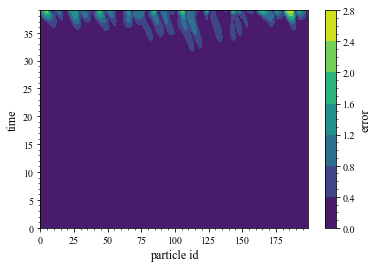

In [41]:
# error plot
nt = 40
error = torch.abs(y_test[0:nt,:] - y_prec[0:nt,:])
[nx, ny] = y_test[0:nt,:].shape
x, y = np.arange(nx), np.arange(ny)
X, Y = np.meshgrid(y, x)
plt.figure()
plt.contourf(X, Y, error)
cbar = plt.colorbar()
cbar.set_label('error')
plt.xlabel('particle id')
plt.ylabel('time')
